**Node2vec**

Node2vec is an random walk algorithm combining **DFS** and **BFS** to genereate walk sequence.

According to the authors, BFS could lead to embeddings that correspond closely to **structural equivalence**, while DFS could reflect a marco-view of the neighborhood, which is called **homophily**. This altorithm use two parametes p and q to control the generation of walk sequence.

Normally, if we step on the current node, and try to decide which node to go in the graph, we would like to use the normalized weights of edges linked to current node as the probability. The authors indeed use this idea, but also, they came up with a new idea to control random walk. 

Intuitively, there're three types of next node could be the neighbors of current node. First, **the node we come from**. This is true because where we come from should be linked with the current node. Second, **Common neighbors with the node we come from**. To the node we come from, this type of node is on the same level of the current level, so if we go to these nodes, we'd be like performing BFS. Third, **Other neighbors**. These nodes are just neighbors of the current node. If we go to them, we acutlaly perform DFS.

In this case, the author use p, q and the weights of edges to control where we move in the graph.

Same as the previous works, this author also use techniques like alias table to speed up the algorithm. For **each node**, we should calculate the probability of moving to the next one based on the weights of edges. We should construct an alias table for each node. For **each edge**, we should calculate the probability of moving to the next one based on the algorithm we discussed before to decide where to go when we are on the current node.

After pre-computing these two, we could generate walk sequences. To start, we should randomly select a node as the start node. Since now it doesn't have previous node, we should use node alias table to decide where to go. And then, we get edges, so we could use edge alias table to decide where to go. Fianlly, we use skip-gram to calculate the representation.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader

In [ ]:
maxnode = 100
eachedge = maxnode // 50
dataset = {}

for i in range(maxnode):
  n1 = i
  count = 0
  while(count < eachedge):
    n2 = random.randint(0, maxnode - 1)
    w = random.randint(1, 100)
    dataset[(n1, n2)] = w
    count += 1

In [ ]:
class alias():
  def __init__(self, probs):
    self.n = len(probs)
    self.scaledprobs = {}
    self.table = {}
    self.aliastable = {}
    self.small = []
    self.big = []
    self.keys = list(probs.keys())

    for item in probs:
      prob = probs[item]
      self.scaledprobs[item] = prob * self.n
      if self.scaledprobs[item] > 1:
        self.big.append(item)
      elif self.scaledprobs[item] < 1:
        self.small.append(item)
      else:
        self.table[item] = 1
    
    while self.small and self.big:
      smallitem = self.small.pop()
      bigitem = self.big.pop()
      newprob = self.scaledprobs[bigitem] - (1 - self.scaledprobs[smallitem])
      self.table[smallitem] = self.scaledprobs[smallitem]
      self.aliastable[smallitem] = bigitem
      self.scaledprobs[bigitem] = newprob
      if self.scaledprobs[bigitem] > 1:
        self.big.append(bigitem)
      elif self.scaledprobs[bigitem] < 1:
        self.small.append(bigitem)
      else:
        self.table[bigitem] = 1
    
    while self.small:
      smallitem = self.small.pop()
      self.table[smallitem] = 1
    
    while self.big:
      bigitem = self.big.pop()
      self.table[bigitem] = 1

  def sampling_one(self):
    sample = random.choice(self.keys)
    if self.table[sample] >= random.uniform(0, 1):
      return sample
    else:
      return self.aliastable[sample]
  
  def sampling_n(self, n):
    samples = []
    for i in range(n):
      samples.append(self.sampling_one())
    return samples

In [ ]:
neighbors = defaultdict(list)
for key in dataset:
  neighbors[key[0]].append(key[1])

nodes = {}
for node in range(maxnode):
  weightsum = 0
  nodeprob = {}
  for neighbor in neighbors[node]:
    weightsum += dataset[(node, neighbor)]
    nodeprob[neighbor] = dataset[(node, neighbor)]
  for neighbor in neighbors[node]:
    nodeprob[neighbor] /= weightsum
  nodes[node] = alias(nodeprob)

p = 0.5
q = 0.5

edges = {}
for edge in dataset:
  src = edge[0]
  cur = edge[1]
  edgeprob = {}
  weightsum = 0
  for neighbor in neighbors[cur]:
    weightsum += dataset[(cur, neighbor)]
    if neighbor == src:
      edgeprob[(cur, neighbor)] = dataset[(cur, neighbor)] * 1 / p
    elif neighbor in neighbors[src]:
      edgeprob[(cur, neighbor)] = dataset[(cur, neighbor)]
    else:
      edgeprob[(cur, neighbor)] = dataset[(cur, neighbor)] * 1 / q
  for item in edgeprob:
    edgeprob[item] /= weightsum
  edges[edge] = alias(edgeprob)

print("num of nodes: {0}".format(len(nodes)))
print("num of edges: {0}".format(len(edges)))

num of nodes: 100
num of edges: 200


In [ ]:
walk_times = 10
walksz = 10

walks = []
for node in range(maxnode):
  count1 = 0
  while(count1 < walk_times):
    count2 = 1
    walk = [node]
    while (count2 < walksz):
      cur = walk[-1]
      if len(walk) == 1:
        newnode = nodes[cur].sampling_one()
      else:
        prev = walk[-2]
        newnode = edges[(prev, cur)].sampling_one()[1]
      walk.append(newnode)
      count2 += 1
    walks.append(walk)
    count1 += 1

print("num of walks: {0}".format(len(walks)))
print("len of walk: {0}".format(len(walks[0])))

num of walks: 1000
len of walk: 10


In [ ]:
epoch = 200
windowsz = 2
lr = 0.01
batch = 64
wordsz = len(nodes)
featuresz = 32

In [ ]:
def one_hot(node):
  vec = [0] * wordsz
  vec[node] = 1
  return vec

def gen_data(walks):
  sources = []
  targets = []
  for walk in walks:
    for i, node in enumerate(walk):
      source = one_hot(node)
      for j in range(i - windowsz, i + windowsz + 1):
        if j != i and j >= 0 and j < len(walk):
          target = walk[j]
          sources.append(source)
          targets.append(target)
  return torch.Tensor(sources), torch.tensor(targets)

sources, targets = gen_data(walks)

In [ ]:
print(sources.shape)

torch.Size([34000, 100])


In [ ]:
class Node2vec(nn.Module):
  def __init__(self):
    super(Node2vec, self).__init__()
    self.layer1 = nn.Linear(wordsz, featuresz)
    self.layer2 = nn.Linear(featuresz, wordsz)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    return x

In [ ]:
model = Node2vec()
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
trainset = torch.utils.data.TensorDataset(sources, targets)
train_loader = DataLoader(trainset, batch_size=batch, shuffle=True)

In [ ]:
def train():
  model.train()
  for i in range(epoch):
    acc = 0
    for x, y in train_loader:
      pred = model(x)
      loss = criterion(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print("epoch: {0}, loss: {1}".format(i, loss))

In [ ]:
train()

epoch: 0, loss: 4.5624098777771
epoch: 1, loss: 4.543781757354736
epoch: 2, loss: 4.608210563659668
epoch: 3, loss: 4.479526996612549
epoch: 4, loss: 4.479525566101074
epoch: 5, loss: 4.293203830718994
epoch: 6, loss: 4.192351341247559
epoch: 7, loss: 4.615893363952637
epoch: 8, loss: 4.273198127746582
epoch: 9, loss: 4.118351936340332
epoch: 10, loss: 4.173304080963135
epoch: 11, loss: 4.362725257873535
epoch: 12, loss: 4.018477916717529
epoch: 13, loss: 4.13419771194458
epoch: 14, loss: 3.9176063537597656
epoch: 15, loss: 4.474015235900879
epoch: 16, loss: 4.0818400382995605
epoch: 17, loss: 4.409639835357666
epoch: 18, loss: 4.115595817565918
epoch: 19, loss: 3.8949341773986816
epoch: 20, loss: 4.088818073272705
epoch: 21, loss: 4.2559356689453125
epoch: 22, loss: 4.34713077545166
epoch: 23, loss: 4.098065376281738
epoch: 24, loss: 3.9616503715515137
epoch: 25, loss: 3.7248716354370117
epoch: 26, loss: 3.4255001544952393
epoch: 27, loss: 3.7704010009765625
epoch: 28, loss: 3.9166173

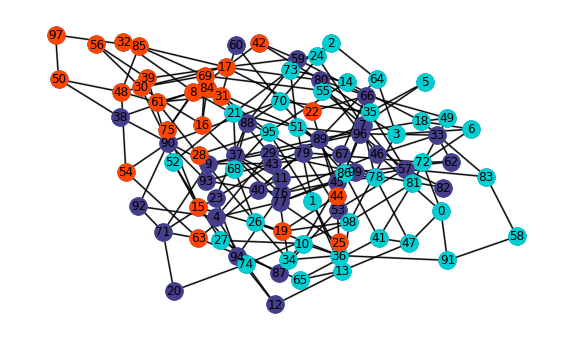

In [ ]:
embedding = model.layer1.weight.T
num_coms = 3
clusters = KMeans(n_clusters=num_coms).fit_predict(embedding.detach().numpy())
communities = []
for i in range(num_coms):
  communities.append(set())
for i in range(len(clusters)):
  communities[clusters[i]].add(i)

G = nx.Graph()
for node in range(maxnode):
  G.add_node(node)

for item in edges:
  G.add_edge(item[0], item[1])

fig = plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos, with_labels=True)
colors = ['#483D8B', '#00CED1', '#FF4500', '#FFD700']
for i in range(num_coms):
  nx.draw_networkx_nodes(G, pos, node_size=300, nodelist=list(communities[i]), node_color=colors[i])
nx.draw_networkx_edges(G, pos, alpha=0.5, width=2)
plt.axis("off")
plt.show()